In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from matplotlib.font_manager import FontProperties


In [2]:
noedf = pd.read_csv('noe_800.dat', header=None, sep=' ')
noedf.columns=['res', 'N', 'noe', 'noe_err']

r1df = pd.read_csv('r1_800.dat', header=None, sep=' ')
r1df.columns=['res', 'N', 'r1', 'r1_err']

r2df = pd.read_csv('r2_800.dat', header=None, sep=' ')
r2df.columns=['res', 'N', 'r2', 'r2_err']

df = noedf.merge(r1df, on='res', how='left')
df = df.merge(r2df, on='res', how='left')

df.dropna(inplace=True)

In [3]:
rnh = 1.02e-10
gammah = 2.6752e8
gamman = -2.71e7
dsigma=-172e-6
mu = 1e-7
hbar = 6.626e-34 / (2*np.pi)

#Larmor frequencies (1/ns)
fieldH=2*3.14159*800.13*0.001
fieldN=-fieldH*gamman/gammah

B0=fieldH*1e9/gammah      #in Tesla

#dipole and CSA coupling constants
dd = ((mu/4*3.1416)*hbar*gammah*gamman/(4*3.1416*rnh**3))**2
cc = (B0*gamman*dsigma/3)**2

In [20]:
def J(params, S2):

    tauc, w0, wN, w087wH = params
    
    J0 = (2/5) * S2*tauc/(1 + np.power((w0*tauc),2))
    JwN = (2/5)*S2*tauc/(1 + np.power((wN*tauc),2))
    J087wH = (2/5)*S2*tauc/(1 + np.power((w087wH*tauc),2))
    
    return J0, JwN, J087wH

def spectral_densities(X):

        NOE, R1, R2 = X
##        sigmanh = (NOE -1)*R1*(gamman/gammah)
##        J087wH = 4*sigmanh/(5*dd)
##        JwN = (7/20)*((0.87/0.921)**2)*sigmanh/(3*dd+4*cc)
        J087wH = (1/(5*dd))*(gamman/gammah)*(1-NOE)*R1
        JwH = 0.7569*J087wH
        J0921wH = 0.8923*J087wH
        J0 = (2*R2 - R1 - 6*dd*JwH)/(4*(dd+cc))
        JwN = (R1 - 7*dd*J0921wH)/(3*(dd+cc))
        return J0, JwN, J087wH

def calc_S2(res, NOE, R1, R2):
    S2_list = []
    tauc_list = []

    for i in range(len(res)):
        X = NOE[i], R1[i], R2[i]

        tauc = 12e-9 #(1/(2*larmorn))*((6*(1/R1[i])/(1/R2[i]))-7)**0.5
        larmorn = fieldN*1e9
        tauc_list.append(tauc)
        params = tauc, 0, fieldN, 0.87*fieldN
        SD = spectral_densities(X)
        p0 = [0.9]
        popt, pcov = curve_fit(J, params, SD, p0, method='lm')   
        S2_list.append(popt[0])


In [21]:
def reformat_data(res, data, error):
    data_list = list(data)
    error_list = list(error)
    title = 'some data'
    #Plotting
    new_data = []
    new_err = []
    new_res = np.linspace(1,330, num=330)
    res = list(res)
    for r in new_res:
        if int(r) in res:
            idx = res.index(r)
            new_data.append(data_list[idx])
            new_err.append(error_list[idx])
        else:
            new_data.append(np.nan)
            new_err.append(np.nan)
            
    new_res = np.array(new_res)
    return new_res, new_data, new_err

# #    plt.bar(new_res, new_data,yerr=new_err, width=1., capsize=1.2, ecolor='grey', color='black')            
# #
# #    plt.title(title)
# #    plt.show()

def plot_func_S2(res, data):
    S2_list = data
    #Plotting
    new_s2 = []
    new_res = np.linspace(1,330, num=330)
    res = list(res)
    for r in new_res:
        if int(r) in res:
            idx = res.index(r)
            new_s2.append(S2_list[idx])
        else:
            new_s2.append(np.nan)
        
    S2_list = np.asarray(new_s2)
    S2_list = np.where(S2_list < 1.0, S2_list, np.nan)
    S2_list = list(S2_list)
    new_res = list(new_res)
    return new_res, S2_list


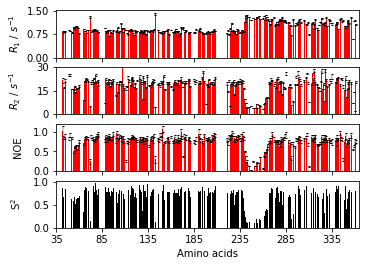

In [23]:
R1 = df['r1'].values
R1_err = df['r1_err'].values

R2 = df['r2'].values
R2_err = df['r2_err'].values

NOE = df['noe'].values
NOE_err = df['noe_err'].values

res = df['res'].values

calc_S2(res, NOE, R1, R2)

nres, R2, R2_err = reformat_data(res, R2, R2_err)
_, R1, R1_err = reformat_data(res, R1, R1_err)
_, NOE, NOE_err = reformat_data(res, NOE, NOE_err)
_, S2 = plot_func_S2(res, S2_list)


fig, axs = plt.subplots(4, 1, sharex=True)
fig.subplots_adjust(left=0.2, wspace=0.8)
fig.align_ylabels(axs)

font0 = FontProperties()
fontx = font0.copy()
fontx.set_style('normal')
fontx.set_family('sans-serif')
fontx.set_size('medium')

errorbars = {
    'ecolor':'black',
    'capsize':0.6,
    'elinewidth':0.4
    }

shift = 34
nres = nres + shift
minx = 1 + shift
maxx = 330 + shift

ax1 = axs[0]
ax1.set_ylabel(r'$R_{1}$ / $s^{-1}$', fontproperties=fontx)
ax1.set_xticks([])
ax1.bar(nres, R1, yerr=R1_err, color='red', width=0.8, error_kw=errorbars)
ax1.set_yticks([0,0.75,1.5])

ax2 = axs[1]
ax2.set_ylabel(r'$R_{2}$ / $s^{-1}$', fontproperties=fontx)
ax2.bar(nres, R2, yerr=R2_err, color='red', width=0.8, error_kw=errorbars)
ax2.set_xticks([])
ax2.set_ylim(0,30)
ax2.set_yticks([0,15,30])

ax3 = axs[2]
ax3.bar(nres, NOE, yerr=NOE_err, color='red', width=0.8, error_kw=errorbars)
ax3.set_ylabel(r'NOE', fontproperties=fontx)
ax3.set_xticks([])
ax3.set_yticks([0,0.5,1.0])

ax4 = axs[3]
ax4.bar(nres, S2, color='black', width=0.8)
ax4.set_ylabel(r'S$^{2}$', fontproperties=fontx)
ax4.set_xlabel('Amino acids', fontproperties=fontx)
ax4.set_xticks(np.arange(minx, maxx, step=50))
ax4.set_yticks([0,0.5,1.0])
ax4.set_xlim(minx,maxx)

plt.savefig('flcels2_relaxation.png', dpi=300)
plt.show()